# Dataset

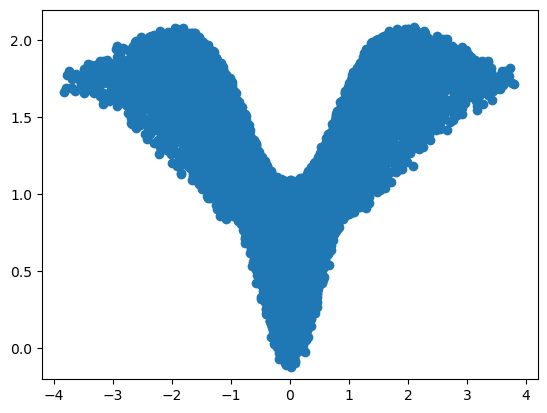

In [ ]:
import matplotlib.pyplot as plt
import torch


def synthetic_dataset(n: int, p: int = 1, condition_on_x: torch.Tensor = None):
    """Synthetic dataset from https://arxiv.org/abs/2110.00816, Appendix B.1.

    Args:
        n: sample size
        p: number of features. Defaults to 1 (used in the paper).
        condition_on_x: If None, generates marginal model. If Tesor, expects shape (1, p).
    """
    beta_hat = torch.rand(size=(n, p))
    beta = beta_hat / torch.linalg.norm(beta_hat, ord=1, dim=1, keepdim=True)
    z = 2 * torch.pi * torch.rand(size=(n, p)) - torch.pi
    phi = 2 * torch.pi * torch.rand(size=(n, p))
    r = 2 * 0.1 * torch.rand(size=(n, p)) - 0.1
    if condition_on_x is None:
        x = (3.2 - 0.8) * torch.rand(size=(n, p)) + 0.8
        y_0 = z / (beta * x).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(x.mean(dim=1, keepdim=True))
    else:
        x = condition_on_x
        y_0 = z / (beta * x).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(x.mean(dim=1, keepdim=True))

    return x, y_0, y_1


# Marginal of Y = (Y_0, Y_1), Fig. 1 (left) of https://arxiv.org/abs/2110.00816
_, y_0, y_1 = synthetic_dataset(n=20000, p=1)
fig, ax = plt.subplots()
offset = 0.2
ax.set_xlim(-4 - offset, 4 + offset)
ax.set_ylim(0 - offset, 2 + offset)
ax.scatter(y_0, y_1)

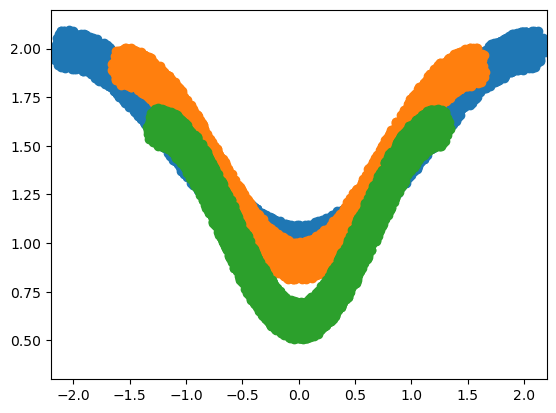

In [80]:
# Condition of Y = (Y_0, Y_1) | X = [1.5, 2, 2.5], Fig. 1 (right) of https://arxiv.org/abs/2110.00816
fig, ax = plt.subplots(ncols=1)
x = [1.5, 2.0, 2.5]
offset = 0.2
ax.set_xlim(-2 - offset, 2 + offset)
ax.set_ylim(0.5 - offset, 2 + offset)
for j in range(3):
    _, y_0, y_1 = synthetic_dataset(n=20000, condition_on_x=torch.Tensor([x[j]]).reshape(-1, 1))
    ax.scatter(y_0, y_1)

# Naive Multivariate Conformalized Quantile Regression (Use This!)

In [247]:
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import math


def pinball_loss(input: torch.Tensor, target: torch.Tensor, gamma: float):
    """Pinball loss of https://arxiv.org/pdf/2107.07511 (page 8) to learn (gamma/2)-quantiles.

    Args:
        input: Model output.
        target: Ground truth.
        gamma: Quantile to regress.

    """
    errors = target - input
    loss = torch.maximum(errors * gamma, -errors * (1 - gamma)).mean()
    return loss


def make_mlp(
    input_dim: int = 1,
    output_dim: int = 2,
    layer_size: int = 32,
    n_hidden: int = 2,
    activation: torch.nn.Module = torch.nn.ELU,
):
    layers = [Linear(input_dim, layer_size), activation(), BatchNorm1d(layer_size)]
    for _ in range(n_hidden - 1):
        layers += [Linear(layer_size, layer_size), activation(), BatchNorm1d(layer_size)]
    layers += [Linear(layer_size, output_dim), activation()]
    return Sequential(*layers)


# CONFIG================================================================================================================
SAMPLE_SIZE = 20000  # (Table 4)
BATCH_SIZE = 256  # (Appendix C)
EPOCHS = 1000
DEVICE = "cuda:0"
ALPHA = 0.05  # This is multiplied by the output dimension

# GET DATA==============================================================================================================
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1)
y = torch.hstack([y_0, y_1])

# Split dataset intro train, calibration, validation, and test
ntrain, ncal, nval, ntest = (
    int(0.384 * SAMPLE_SIZE),
    int(0.256 * SAMPLE_SIZE),
    int(0.16 * SAMPLE_SIZE),
    int(0.2 * SAMPLE_SIZE),
)
x_train, y_train = x[:ntrain, :], y[:ntrain, :]
x_cal, y_cal = x[ntrain : ntrain + ncal, :], y[ntrain : ntrain + ncal, :]
x_val, y_val = x[ntrain + ncal : ntrain + ncal + nval, :], y[ntrain + ncal : ntrain + ncal + nval, :]
x_test, y_test = x[ntrain + ncal + nval :, :], y[ntrain + ncal + nval :, :]
print(f"Sanity check: train={x_train.shape[0]}, cal={x_cal.shape[0]}, val={x_val.shape[0]}, test={x_test.shape[0]}")

# Standardize datasets
x_train_mean = x_train.mean(dim=0)
y_train_mean = y_train.mean(dim=0)

x_train_std = x_train.std(dim=0)
y_train_std = y_train.std(dim=0)

x_train = (x_train - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std

x_cal = (x_cal - x_train_mean) / x_train_std
y_cal = (y_cal - y_train_mean) / y_train_std

x_val = (x_val - x_train_mean) / x_train_std
y_val = (y_val - y_train_mean) / y_train_std

x_test = (x_test - x_train_mean) / x_train_std
y_test = (y_test - y_train_mean) / y_train_std

# Wrap tensors into Dataset and DataLoader
train_ds = TensorDataset(x_train, y_train)
cal_ds = TensorDataset(x_cal, y_cal)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
cal_dl = DataLoader(cal_ds, shuffle=False, batch_size=len(cal_ds))
val_dl = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

# GET MODEL=============================================================================================================
# TODO: Implement multivariate QR as in the paper
lower_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden=3).to(DEVICE)
upper_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden=3).to(DEVICE)

# TRAIN MODEL===========================================================================================================
# TODO: Change to a single model
opt_lo = torch.optim.Adam(lower_quantile_estimator.parameters())
opt_up = torch.optim.Adam(upper_quantile_estimator.parameters())


def train(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    train_dl: DataLoader,
    opt_lo: torch.optim.Optimizer,
    opt_up: torch.optim.Optimizer,
):
    lo_q_est.train()
    up_q_est.train()
    for batch, (x, y) in enumerate(train_dl):
        x, y = x.to(DEVICE), y.to(DEVICE)
        q_lo, q_up = lo_q_est(x), up_q_est(x)

        loss_lo = pinball_loss(input=q_lo, target=y, gamma=ALPHA / 2)
        loss_up = pinball_loss(input=q_up, target=y, gamma=1 - ALPHA / 2)

        loss_lo.backward()
        loss_up.backward()

        opt_lo.step()
        opt_up.step()

        opt_lo.zero_grad()
        opt_up.zero_grad()


for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(
        lo_q_est=lower_quantile_estimator,
        up_q_est=upper_quantile_estimator,
        train_dl=train_dl,
        opt_lo=opt_lo,
        opt_up=opt_up,
    )

    # if epoch % 25 == 0:
    # validate()

# CALIBRATION===========================================================================================================


def calibrate(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    cal_ds: TensorDataset,
):
    lo_q_est.eval()
    up_q_est.eval()
    n_cal = len(cal_ds)
    adjusted_alpha = math.ceil((n_cal + 1) * (1 - ALPHA)) / n_cal

    with torch.no_grad():
        x, y = cal_ds.tensors
        x, y = x.to(DEVICE), y.to(DEVICE)

        q_lo, q_up = lo_q_est(x), up_q_est(x)

        nonconformity_scores = torch.maximum(q_lo - y, y - q_up).max(dim=1, keepdim=True)[0]

        q_hat = torch.quantile(nonconformity_scores, adjusted_alpha, interpolation="higher").item()

        return q_hat


q_hat = calibrate(lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, cal_ds=cal_ds)
print(f"Empirical Quantile Estimated with CP: {q_hat}")


# EVALUATION============================================================================================================


def test(lo_q_est: torch.nn.Module, up_q_est: torch.nn.Module, test_dl: DataLoader, q_hat: float):
    coverage = 0
    set_size = 0
    lo_q_est.eval()
    up_q_est.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Conformalize quantile estimates
            q_lo, q_up = lo_q_est(x) - q_hat, up_q_est(x) + q_hat

            coverage += ((q_lo <= y).all(dim=1, keepdim=True) & (y <= q_up).all(dim=1, keepdim=True)).type_as(y).mean()
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


coverage, set_size = test(
    lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, test_dl=test_dl, q_hat=q_hat
)
print(f"Avg. empirical coverage: {coverage.item() * 100:.2f}% Avg. set size: {set_size.item():.2f}")


Sanity check: train=7680, cal=5120, val=3200, test=4000
EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4
EPOCH: 5
EPOCH: 6
EPOCH: 7
EPOCH: 8
EPOCH: 9
EPOCH: 10
EPOCH: 11
EPOCH: 12
EPOCH: 13
EPOCH: 14
EPOCH: 15
EPOCH: 16
EPOCH: 17
EPOCH: 18
EPOCH: 19
EPOCH: 20
EPOCH: 21
EPOCH: 22
EPOCH: 23
EPOCH: 24
EPOCH: 25
EPOCH: 26
EPOCH: 27
EPOCH: 28
EPOCH: 29
EPOCH: 30
EPOCH: 31
EPOCH: 32
EPOCH: 33
EPOCH: 34
EPOCH: 35
EPOCH: 36
EPOCH: 37
EPOCH: 38
EPOCH: 39
EPOCH: 40
EPOCH: 41
EPOCH: 42
EPOCH: 43
EPOCH: 44
EPOCH: 45
EPOCH: 46
EPOCH: 47
EPOCH: 48
EPOCH: 49
EPOCH: 50
EPOCH: 51
EPOCH: 52
EPOCH: 53
EPOCH: 54
EPOCH: 55
EPOCH: 56
EPOCH: 57
EPOCH: 58
EPOCH: 59
EPOCH: 60
EPOCH: 61
EPOCH: 62
EPOCH: 63
EPOCH: 64
EPOCH: 65
EPOCH: 66
EPOCH: 67
EPOCH: 68
EPOCH: 69
EPOCH: 70
EPOCH: 71
EPOCH: 72
EPOCH: 73
EPOCH: 74
EPOCH: 75
EPOCH: 76
EPOCH: 77
EPOCH: 78
EPOCH: 79
EPOCH: 80
EPOCH: 81
EPOCH: 82
EPOCH: 83
EPOCH: 84
EPOCH: 85
EPOCH: 86
EPOCH: 87
EPOCH: 88
EPOCH: 89
EPOCH: 90
EPOCH: 91
EPOCH: 92
EPOCH: 93
EPOCH: 94
EPOC

In [ ]:
# Quantile Regression, Fig 2 of https://arxiv.org/abs/2110.00816
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1, condition_on_x=torch.Tensor([1.5]).reshape(1, 1))
y = torch.hstack([y_0, y_1])

In [244]:
# (torch.rand(size=(100, 1)) >= 0.5).type_as(y).mean()
# torch.Tensor([True & False, True & True]).type_as(torch.Tensor([2.5])).mean()
# len(cal_ds)
# x, y = cal_ds.tensors
# x
# (torch.rand(size=(4, 2)) <= 0.3).all(dim=1, keepdim=True)
# x = torch.rand(size=(4, 1))
# y = torch.rand(size=(4, 1))
# print(x)
# print(y)
# torch.hstack([x, y])
torch.rand(size=(4, 2)).max(dim=1, keepdim=True)[0]

tensor([[0.7284],
        [0.6903],
        [0.8382],
        [0.2594]])

# Naive Univariate Conformalized Quantile Regression

In [ ]:
# Quantile Regression, Fig 2 of https://arxiv.org/abs/2110.00816
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import math


def pinball_loss(input: torch.Tensor, target: torch.Tensor, gamma: float):
    """Pinball loss of https://arxiv.org/pdf/2107.07511 (page 8) to learn (gamma/2)-quantiles.

    Args:
        input: Model output.
        target: Ground truth.
        gamma: Quantile to regress.

    """
    errors = target - input
    loss = torch.maximum(errors * gamma, -errors * (1 - gamma)).mean()
    return loss


def make_mlp(
    input_dim: int = 1,
    output_dim: int = 2,
    layer_size: int = 32,
    n_hidden: int = 2,
    activation: torch.nn.Module = torch.nn.ELU,
):
    layers = [Linear(input_dim, layer_size), activation(), BatchNorm1d(layer_size)]
    for _ in range(n_hidden - 1):
        layers += [Linear(layer_size, layer_size), activation(), BatchNorm1d(layer_size)]
    layers += [Linear(layer_size, output_dim), activation()]
    return Sequential(*layers)


# CONFIG================================================================================================================
SAMPLE_SIZE = 20000  # (Table 4)
BATCH_SIZE = 256  # (Appendix C)
EPOCHS = 1000
DEVICE = "cuda:0"
ALPHA = 0.05

# GET DATA==============================================================================================================
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1)
# y = torch.hstack([y_0, y_1])
y = y_0  # TODO: HOW TO DO THIS??

# Split dataset intro train, calibration, validation, and test
ntrain, ncal, nval, ntest = (
    int(0.384 * SAMPLE_SIZE),
    int(0.256 * SAMPLE_SIZE),
    int(0.16 * SAMPLE_SIZE),
    int(0.2 * SAMPLE_SIZE),
)
x_train, y_train = x[:ntrain, :], y[:ntrain, :]
x_cal, y_cal = x[ntrain : ntrain + ncal, :], y[ntrain : ntrain + ncal, :]
x_val, y_val = x[ntrain + ncal : ntrain + ncal + nval, :], y[ntrain + ncal : ntrain + ncal + nval, :]
x_test, y_test = x[ntrain + ncal + nval :, :], y[ntrain + ncal + nval :, :]
print(f"Sanity check: train={x_train.shape[0]}, cal={x_cal.shape[0]}, val={x_val.shape[0]}, test={x_test.shape[0]}")

# Standardize datasets
x_train_mean = x_train.mean(dim=0)
y_train_mean = y_train.mean(dim=0)

x_train_std = x_train.std(dim=0)
y_train_std = y_train.std(dim=0)

x_train = (x_train - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std

x_cal = (x_cal - x_train_mean) / x_train_std
y_cal = (y_cal - y_train_mean) / y_train_std

x_val = (x_val - x_train_mean) / x_train_std
y_val = (y_val - y_train_mean) / y_train_std

x_test = (x_test - x_train_mean) / x_train_std
y_test = (y_test - y_train_mean) / y_train_std

# Wrap tensors into Dataset and DataLoader
train_ds = TensorDataset(x_train, y_train)
cal_ds = TensorDataset(x_cal, y_cal)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
cal_dl = DataLoader(cal_ds, shuffle=False, batch_size=len(cal_ds))
val_dl = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

# GET MODEL=============================================================================================================
# TODO: Implement multivariate QR as in the paper
lower_quantile_estimator = make_mlp(output_dim=1, layer_size=64, n_hidden=3).to(DEVICE)
upper_quantile_estimator = make_mlp(output_dim=1, layer_size=64, n_hidden=3).to(DEVICE)

# TRAIN MODEL===========================================================================================================
# TODO: Change to a single model
opt_lo = torch.optim.Adam(lower_quantile_estimator.parameters())
opt_up = torch.optim.Adam(upper_quantile_estimator.parameters())


def train(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    train_dl: DataLoader,
    opt_lo: torch.optim.Optimizer,
    opt_up: torch.optim.Optimizer,
):
    lo_q_est.train()
    up_q_est.train()
    for batch, (x, y) in enumerate(train_dl):
        x, y = x.to(DEVICE), y.to(DEVICE)
        q_lo, q_up = lo_q_est(x), up_q_est(x)

        loss_lo = pinball_loss(input=q_lo, target=y, gamma=ALPHA / 2)
        loss_up = pinball_loss(input=q_up, target=y, gamma=1 - ALPHA / 2)

        loss_lo.backward()
        loss_up.backward()

        opt_lo.step()
        opt_up.step()

        opt_lo.zero_grad()
        opt_up.zero_grad()


for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(
        lo_q_est=lower_quantile_estimator,
        up_q_est=upper_quantile_estimator,
        train_dl=train_dl,
        opt_lo=opt_lo,
        opt_up=opt_up,
    )

    # if epoch % 25 == 0:
    # validate()

# CALIBRATION===========================================================================================================


def calibrate(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    cal_ds: TensorDataset,
):
    lo_q_est.eval()
    up_q_est.eval()
    n_cal = len(cal_ds)
    adjusted_alpha = math.ceil((n_cal + 1) * (1 - ALPHA)) / n_cal

    with torch.no_grad():
        x, y = cal_ds.tensors
        x, y = x.to(DEVICE), y.to(DEVICE)

        q_lo, q_up = lo_q_est(x), up_q_est(x)

        nonconformity_scores = torch.maximum(q_lo - y, y - q_up)

        q_hat = torch.quantile(nonconformity_scores, adjusted_alpha, interpolation="higher").item()

        return q_hat


q_hat = calibrate(lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, cal_ds=cal_ds)
print(f"Empirical Quantile Estimated with CP: {q_hat}")


# EVALUATION============================================================================================================


def test(lo_q_est: torch.nn.Module, up_q_est: torch.nn.Module, test_dl: DataLoader, q_hat: float):
    coverage = 0
    interval_size = 0
    lo_q_est.eval()
    up_q_est.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Conformalize quantile estimates
            q_lo, q_up = lo_q_est(x) - q_hat, up_q_est(x) + q_hat

            coverage += ((q_lo <= y) & (y <= q_up)).type_as(y).mean()
            interval_size += (q_up - q_lo).abs().mean()
    coverage /= len(test_dl)
    interval_size /= len(test_dl)

    return coverage, interval_size


coverage, interval_size = test(
    lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, test_dl=test_dl, q_hat=q_hat
)
print(f"Avg. empirical coverage: {coverage.item() * 100:.2f}% Avg. set size: {interval_size.item():.2f}")


tensor(0.9451)